# andre marroquin 22266

## Imports básicos y carga de datos

In [10]:
# imprts de las libs utiles
import math
import re
from collections import Counter
from urllib.parse import urlparse

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# cargar dataset
dataPath = "dataset_pishing.csv"
df = pd.read_csv(dataPath)

print(df.head())
print(df["status"].value_counts())


                                                 url      status
0              http://www.crestonwood.com/router.php  legitimate
1  http://shadetreetechnology.com/V4/validation/a...    phishing
2  https://support-appleld.com.secureupdate.duila...    phishing
3                                 http://rgipt.ac.in  legitimate
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


## EDA

In [11]:
# resumen general del dataset
print("shape:", df.shape)
print("\ncolumnas:", df.columns.tolist())
print("\ninfo:")
display(df.info())

print("\nvalores nulos por columna:")
display(df.isna().sum().to_frame("nullCount"))

print("\nfilas duplicadas (todas las columnas):", df.duplicated().sum())
print("urls duplicadas:", df["url"].duplicated().sum())

print("\nejemplos por clase:")
display(df.groupby("status").head(3))


shape: (11430, 2)

columnas: ['url', 'status']

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


None


valores nulos por columna:


,nullCount
url,0
status,0



filas duplicadas (todas las columnas): 1
urls duplicadas: 1

ejemplos por clase:


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate
5,http://appleid.apple.com-app.es/,phishing


count    11430.000000
mean        61.120035
std         55.292470
min         12.000000
25%         33.000000
50%         47.000000
75%         71.000000
max       1641.000000
Name: urlLengthRaw, dtype: float64


<Figure size 640x480 with 0 Axes>

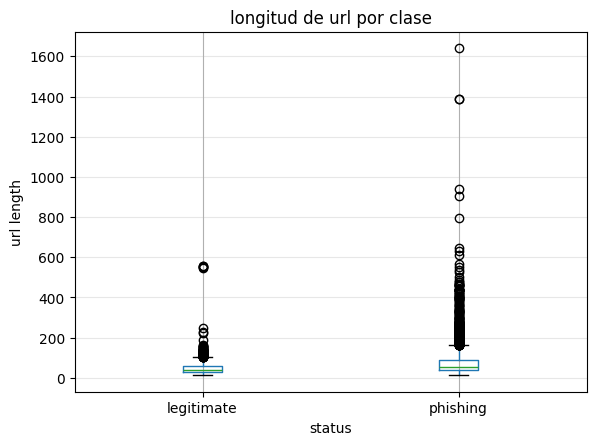

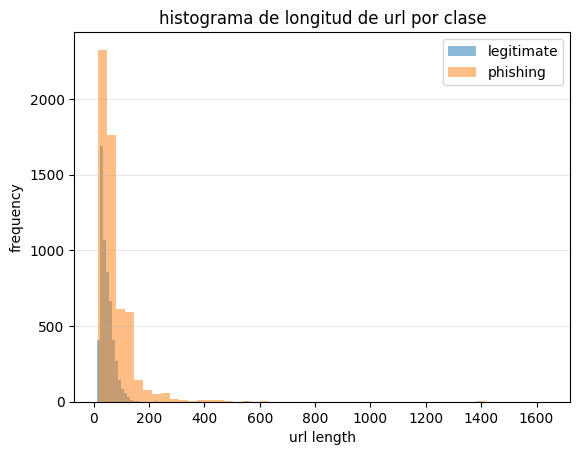

In [12]:
# analisis de longitud de url 
df["urlLengthRaw"] = df["url"].astype(str).apply(len)

print(df["urlLengthRaw"].describe())

plt.figure()
df.boxplot(column="urlLengthRaw", by="status")
plt.title("longitud de url por clase")
plt.suptitle("")
plt.xlabel("status")
plt.ylabel("url length")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

plt.figure()
for statusValue in df["status"].unique():
    subset = df[df["status"] == statusValue]["urlLengthRaw"]
    plt.hist(subset, bins=50, alpha=0.5, label=statusValue)

plt.title("histograma de longitud de url por clase")
plt.xlabel("url length")
plt.ylabel("frequency")
plt.legend()
plt.grid(True, axis="y", alpha=0.3)
plt.show()


,count_.,count_-,count_@,count_?,count_&,count_=,count_%,count__,count_/
status,,,,,,,,,
legitimate,2.197,1.206,0.000,0.034,0.022,0.060,0.082,0.281,3.834
phishing,2.764,0.789,0.044,0.248,0.302,0.526,0.164,0.364,4.746


<Figure size 1000x400 with 0 Axes>

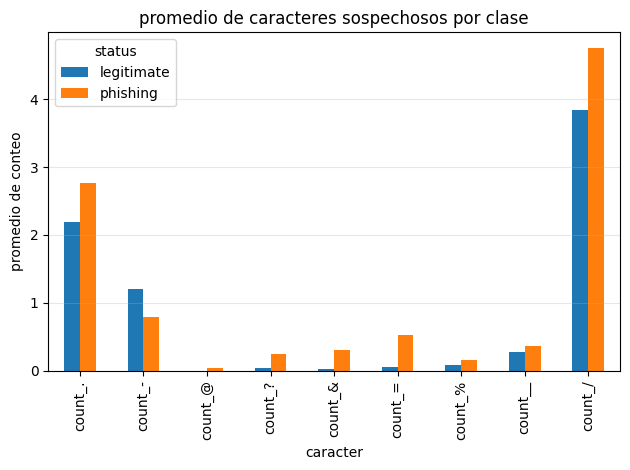

In [13]:
# conteos simples de caracteres sospechosos 
suspiciousChars = [".", "-", "@", "?", "&", "=", "%", "_", "/"]

for ch in suspiciousChars:
    df[f"count_{ch}"] = df["url"].astype(str).apply(lambda x: x.count(ch))

charMeansByStatus = df.groupby("status")[[f"count_{ch}" for ch in suspiciousChars]].mean().round(3)
display(charMeansByStatus)

plt.figure(figsize=(10, 4))
charMeansByStatus.T.plot(kind="bar")
plt.title("promedio de caracteres sospechosos por clase")
plt.xlabel("caracter")
plt.ylabel("promedio de conteo")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


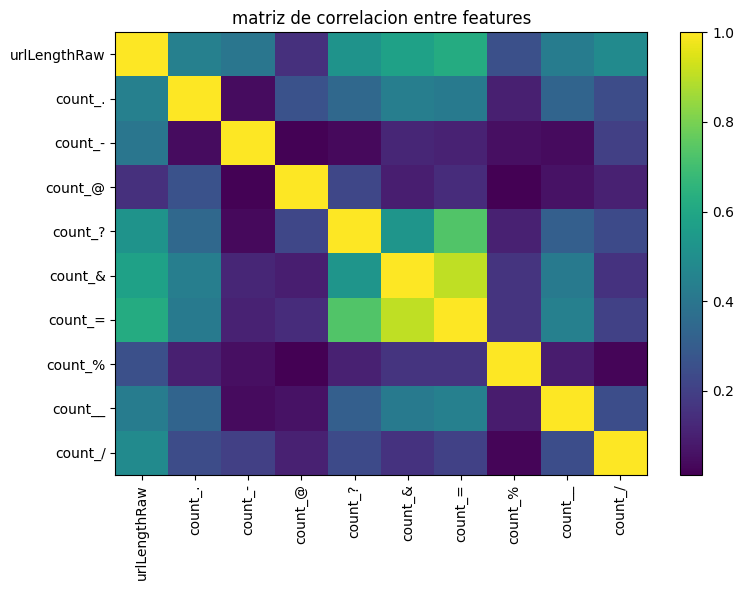

In [14]:
# orrelación entre features
corrMatrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corrMatrix, aspect="auto")
plt.title("matriz de correlacion entre features")
plt.xticks(range(len(corrMatrix.columns)), corrMatrix.columns, rotation=90)
plt.yticks(range(len(corrMatrix.columns)), corrMatrix.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


El EDA muestra que el dataset está limpio y balanceado, sin valores nulos y con un número mínimo de duplicados. Se observa que las URLs de phishing tienden a ser más largas y presentan mayor uso de caracteres y símbolos sospechosos, especialmente aquellos asociados a ofuscación y parámetros. El análisis de correlación confirma que estas características estructurales están relacionadas entre sí y son relevantes para diferenciar URLs legítimas de phishing.

## Funciones helper para parsear URLs

In [15]:
# devuelve el hostname en minusculas a partir de una url
def getHostname(url):
    try:
        parsed = urlparse(str(url))
        if parsed.netloc:
            return parsed.netloc.lower()
        return str(url).split("/")[0].lower()
    except Exception:
        return ""
    
# devuelve el path de la url o una ruta por defecto si no existe
def getPath(url):
    try:
        parsed = urlparse(str(url))
        if parsed.path:
            return parsed.path
        parts = str(url).split("/", 1)
        return "/" + parts[1] if len(parts) > 1 else "/"
    except Exception:
        return "/"

# cuenta cuantas veces aparece un caracter en la url
def countChar(url, char):
    return str(url).count(char)

# cuenta la cantidad total de digitos en la url
def countDigits(url):
    return sum(ch.isdigit() for ch in str(url))

# calcula la proporcion de digitos respecto al largo total de la url
def getDigitRatio(url):
    text = str(url)
    if len(text) == 0:
        return 0.0
    return countDigits(text) / len(text)

ipRegex = re.compile(r"(?:\d{1,3}\.){3}\d{1,3}")

# detecta si el hostname contiene una direccion ip
def hasIpAddress(url):
    hostname = getHostname(url)
    return 1 if ipRegex.search(hostname) else 0

sensitiveWords = ["confirm", "account", "banking", "secure", "login", "signin"]

# detecta si la url contiene palabras sensibles usadas en phishing
def hasSensitiveWords(url):
    text = str(url).lower()
    return 1 if any(word in text for word in sensitiveWords) else 0

# detecta doble slash sospechoso dentro del path
def hasDoubleSlashRedirect(url):
    parsed = urlparse(str(url))
    path = parsed.path or ""
    cleanedPath = path.strip("/")
    return 1 if "//" in cleanedPath else 0

# detecta si el dominio incluye el token https sin usar esquema https real
def hasHttpsTokenInDomain(url):
    parsed = urlparse(str(url))
    scheme = parsed.scheme.lower()
    hostname = getHostname(url)
    if "https" in hostname and scheme != "https":
        return 1
    return 0

# extrae los caracteres no alfanumericos de la url
def getNonAlnumChars(url):
    return [ch for ch in str(url) if not ch.isalnum() and not ch.isspace()]


## Entropía de Shannon y entropía relativa

In [16]:
# calcula la entropia de shannon para una secuencia de caracteres
def computeShannonEntropy(sequence):
    chars = list(sequence)
    if len(chars) == 0:
        return 0.0

    counts = Counter(chars)
    total = len(chars)
    entropy = 0.0

    for char, count in counts.items():
        p = count / total
        entropy -= p * math.log2(p)

    return entropy

# entropia relativa entre distribución empírica y distribución de referencia
def computeRelativeEntropy(sequence, referenceDistribution):
    chars = list(sequence)
    if len(chars) == 0:
        return 0.0

    counts = Counter(chars)
    total = len(chars)
    relativeEntropy = 0.0

    for char, count in counts.items():
        p = count / total
        q = referenceDistribution.get(char)
        if p > 0 and q is not None and q > 0:
            relativeEntropy += p * math.log2(p / q)

    return relativeEntropy

# construir distribución de referencia de caracteres no alfanuméricos
allNanChars = []

for url in df["url"]:
    allNanChars.extend(getNonAlnumChars(url))

if len(allNanChars) > 0:
    totalNan = len(allNanChars)
    nanCounts = Counter(allNanChars)
    referenceNanDistribution = {
        char: count / totalNan
        for char, count in nanCounts.items()
    }
else:
    referenceNanDistribution = {}
    

# funciones específicas para la URL
def getNanEntropy(url):
    nanChars = getNonAlnumChars(url)
    return computeShannonEntropy(nanChars)

def getNanRelativeEntropy(url):
    nanChars = getNonAlnumChars(url)
    return computeRelativeEntropy(nanChars, referenceNanDistribution)





## 15 funciones de características basadas en la URL
### inspiradas en los articulos de la tarea... logitudes, caracteres etc

In [17]:
# funciones para extraer caracteristicas numericas y banderas de riesgo a partir de una url
def getUrlLength(url):
    return len(str(url))

def getHostnameLength(url):
    hostname = getHostname(url)
    return len(hostname)

def getPathLength(url):
    path = getPath(url)
    return len(path)

def getDotCount(url):
    return countChar(url, ".")

def getDashCount(url):
    return countChar(url, "-")

def getAtCount(url):
    return countChar(url, "@")

def getQuestionCount(url):
    return countChar(url, "?")

def getDigitCount(url):
    return countDigits(url)

def getDigitRatioFeature(url):
    return getDigitRatio(url)

def getIpAddressFlag(url):
    return hasIpAddress(url)

def getSensitiveWordsFlag(url):
    return hasSensitiveWords(url)

def getDoubleSlashRedirectFlag(url):
    return hasDoubleSlashRedirect(url)

def getHttpsTokenInDomainFlag(url):
    return hasHttpsTokenInDomain(url)

def getNanEntropyFeature(url):
    return getNanEntropy(url)

def getNanRelativeEntropyFeature(url):
    return getNanRelativeEntropy(url)


Las 15 características fueron seleccionadas porque permiten identificar patrones comunes en URLs de phishing sin necesidad de analizar el contenido de la página ni usar información externa. 

Se incluyeron longitudes de la URL y sus componentes, conteos de caracteres y símbolos especiales, así como patrones frecuentes como el uso de direcciones IP, redirecciones y tokens engañosos como “https”.

Además, se incorporaron la entropía de Shannon y la entropía relativa de caracteres no alfanuméricos para medir el nivel de desorden en la URL, lo que ayuda a diferenciar de forma efectiva entre URLs legítimas y URLs manipuladas.

## Aplicacion de dichas funciones

In [18]:
# se construye un dataframe de features aplicando las funciones de extraccion a cada url del dataset
featureDf = pd.DataFrame()

featureDf["urlLength"] = df["url"].apply(getUrlLength)
featureDf["hostnameLength"] = df["url"].apply(getHostnameLength)
featureDf["pathLength"] = df["url"].apply(getPathLength)

featureDf["dotCount"] = df["url"].apply(getDotCount)
featureDf["dashCount"] = df["url"].apply(getDashCount)
featureDf["atCount"] = df["url"].apply(getAtCount)
featureDf["questionCount"] = df["url"].apply(getQuestionCount)

featureDf["digitCount"] = df["url"].apply(getDigitCount)
featureDf["digitRatio"] = df["url"].apply(getDigitRatioFeature)

featureDf["hasIpAddress"] = df["url"].apply(getIpAddressFlag)
featureDf["hasSensitiveWords"] = df["url"].apply(getSensitiveWordsFlag)
featureDf["hasDoubleSlashRedirect"] = df["url"].apply(getDoubleSlashRedirectFlag)
featureDf["hasHttpsTokenInDomain"] = df["url"].apply(getHttpsTokenInDomainFlag)

featureDf["nanEntropy"] = df["url"].apply(getNanEntropyFeature)
featureDf["nanRelativeEntropy"] = df["url"].apply(getNanRelativeEntropyFeature)

print(featureDf.head())
print(featureDf.shape)


   urlLength  hostnameLength  pathLength  dotCount  dashCount  atCount  \
0         37              19          11         3          0        0   
1         77              23          47         1          0        0   
2        126              50          20         4          1        0   
3         18              11          13         2          0        0   
4         55              15          33         2          2        0   

   questionCount  digitCount  digitRatio  hasIpAddress  hasSensitiveWords  \
0              0           0    0.000000             0                  0   
1              0          17    0.220779             0                  0   
2              1          19    0.150794             0                  1   
3              0           0    0.000000             0                  0   
4              0           0    0.000000             0                  0   

   hasDoubleSlashRedirect  hasHttpsTokenInDomain  nanEntropy  \
0                       0   

## Preprocesamiento status binario y eliminación de la URL

In [19]:
# se crea el dataset final copiando las features y codificando la etiqueta status a valores binarios
data = featureDf.copy()

# se convierte a bin el status
data["status"] = df["status"].map({"legitimate": 0, "phishing": 1})

print(data["status"].value_counts(dropna=False))
print(data.isna().sum())


status
0    5715
1    5715
Name: count, dtype: int64
urlLength                 0
hostnameLength            0
pathLength                0
dotCount                  0
dashCount                 0
atCount                   0
questionCount             0
digitCount                0
digitRatio                0
hasIpAddress              0
hasSensitiveWords         0
hasDoubleSlashRedirect    0
hasHttpsTokenInDomain     0
nanEntropy                0
nanRelativeEntropy        0
status                    0
dtype: int64


## Se concatena y luego se borra para que no memorice

In [20]:
fullData = featureDf.copy()
fullData["status"] = data["status"]


## Selección y revisión de características

In [21]:
# se selecciona las columnas de entrada excluyendo la etiqueta status y analiza estadisticas basicas y correlacion
featureColumns = [col for col in fullData.columns if col != "status"]

# muestra estadisticas de varianza y rango de cada feature
print(fullData[featureColumns].describe().T[["mean", "std", "min", "max"]])

# calcula la correlacion de cada feature con la etiqueta
correlations = fullData[featureColumns + ["status"]].corr()["status"].sort_values(ascending=False)
print(correlations)

# define las features finales a utilizar en el modelo
selectedFeatures = featureColumns
print("selectedFeatures:", selectedFeatures)


                             mean        std        min          max
urlLength               61.120035  55.292470  12.000000  1641.000000
hostnameLength          21.100175  10.778330   4.000000   214.000000
pathLength              24.445407  27.227120   1.000000   602.000000
dotCount                 2.480665   1.369685   1.000000    24.000000
dashCount                0.997550   2.087087   0.000000    43.000000
atCount                  0.022222   0.155500   0.000000     4.000000
questionCount            0.141207   0.364456   0.000000     3.000000
digitCount               5.452143  16.319904   0.000000   679.000000
digitRatio               0.053141   0.089367   0.000000     0.723881
hasIpAddress             0.008486   0.091734   0.000000     1.000000
hasSensitiveWords        0.106824   0.308903   0.000000     1.000000
hasDoubleSlashRedirect   0.000787   0.028051   0.000000     1.000000
hasHttpsTokenInDomain    0.001312   0.036204   0.000000     1.000000
nanEntropy               1.683988 

## Separación de datos (55% / 15% / 30%) y guardado a CSV

In [22]:
# dividir el dataset en train, validation y test
X = fullData[selectedFeatures].values
y = fullData["status"].values

# test = 30%
XTemp, XTest, yTemp, yTest = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# de lo que queda 70%, validación debe ser 15% del total
validationRatio = 15 / 70

XTrain, XVal, yTrain, yVal = train_test_split(
    XTemp,
    yTemp,
    test_size=validationRatio,
    random_state=42,
    stratify=yTemp
)

print("train shape:", XTrain.shape)
print("val shape:", XVal.shape)
print("test shape:", XTest.shape)

# guardar a csv
trainDf = pd.DataFrame(XTrain, columns=selectedFeatures)
trainDf["status"] = yTrain

valDf = pd.DataFrame(XVal, columns=selectedFeatures)
valDf["status"] = yVal

testDf = pd.DataFrame(XTest, columns=selectedFeatures)
testDf["status"] = yTest

trainDf.to_csv("phishing_train.csv", index=False)
valDf.to_csv("phishing_validation.csv", index=False)
testDf.to_csv("phishing_test.csv", index=False)


train shape: (6286, 15)
val shape: (1715, 15)
test shape: (3429, 15)


## Función de evaluación matriz de confusión + métricas + ROC

In [23]:
# evalua un modelo en train validation y test calculando confusion matrix precision recall y auc y grafica la curva roc
def evaluateModel(modelName, model, XTrain, yTrain, XVal, yVal, XTest, yTest, plotRoc=True):
    results = {}

    for splitName, XSplit, ySplit in [
        ("train", XTrain, yTrain),
        ("validation", XVal, yVal),
        ("test", XTest, yTest)
    ]:
        yPred = model.predict(XSplit)
        if hasattr(model, "predict_proba"):
            yScore = model.predict_proba(XSplit)[:, 1]
        else:
            yScore = model.decision_function(XSplit)

        cm = confusion_matrix(ySplit, yPred)
        precision = precision_score(ySplit, yPred)
        recall = recall_score(ySplit, yPred)
        auc = roc_auc_score(ySplit, yScore)

        results[splitName] = {
            "confusionMatrix": cm,
            "precision": precision,
            "recall": recall,
            "auc": auc
        }

        print(f"=== {modelName} - {splitName} ===")
        print("confusion matrix:")
        print(cm)
        print(f"precision:{precision:.4f}")
        print(f"recall:{recall:.4f}")
        print(f"auc:{auc:.4f}")
        print()

    if plotRoc:
        plt.figure()
        for splitName, XSplit, ySplit, color in [
            ("train", XTrain, yTrain, "tab:blue"),
            ("validation", XVal, yVal, "tab:orange"),
            ("test", XTest, yTest, "tab:green")
        ]:
            if hasattr(model, "predict_proba"):
                yScore = model.predict_proba(XSplit)[:, 1]
            else:
                yScore = model.decision_function(XSplit)
            fpr, tpr, _ = roc_curve(ySplit, yScore)
            plt.plot(fpr, tpr, label=f"{splitName}")

        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")
        plt.title(f"roc - {modelName}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return results


## Modelo 1: Regresión logística

=== logistic_regression - train ===
confusion matrix:
[[2703  440]
 [1079 2064]]
precision:0.8243
recall:0.6567
auc:0.8334

=== logistic_regression - validation ===
confusion matrix:
[[730 127]
 [278 580]]
precision:0.8204
recall:0.6760
auc:0.8409

=== logistic_regression - test ===
confusion matrix:
[[1453  262]
 [ 552 1162]]
precision:0.8160
recall:0.6779
auc:0.8324



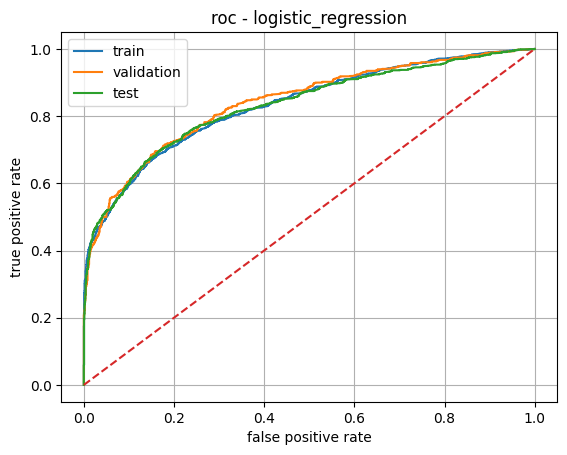

In [24]:
# entrena el modelo de regresion logistica con escalamiento y lo evalua en train validation y test
logisticModel = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logisticModel.fit(XTrain, yTrain)

logisticResults = evaluateModel(
    modelName="logistic_regression",
    model=logisticModel,
    XTrain=XTrain,
    yTrain=yTrain,
    XVal=XVal,
    yVal=yVal,
    XTest=XTest,
    yTest=yTest,
    plotRoc=True
)


## Modelo 2: Random Forest

=== random_forest - train ===
confusion matrix:
[[3097   46]
 [ 159 2984]]
precision:0.9848
recall:0.9494
auc:0.9917

=== random_forest - validation ===
confusion matrix:
[[723 134]
 [137 721]]
precision:0.8433
recall:0.8403
auc:0.9169

=== random_forest - test ===
confusion matrix:
[[1428  287]
 [ 284 1430]]
precision:0.8328
recall:0.8343
auc:0.9166



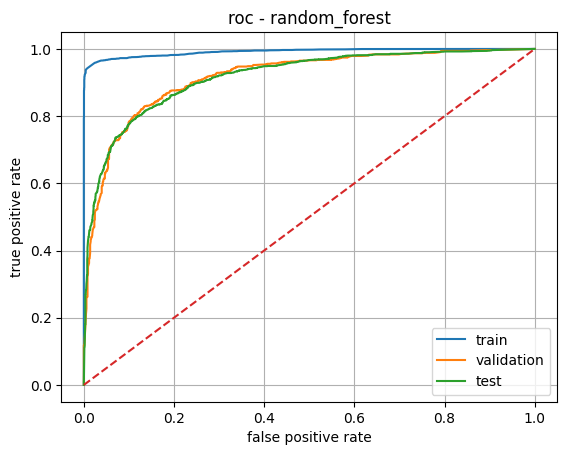

In [25]:
# entrena el modelo random forest y lo evalua en train validation y test
randomForestModel = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

randomForestModel.fit(XTrain, yTrain)

randomForestResults = evaluateModel(
    modelName="random_forest",
    model=randomForestModel,
    XTrain=XTrain,
    yTrain=yTrain,
    XVal=XVal,
    yVal=yVal,
    XTest=XTest,
    yTest=yTest,
    plotRoc=True
)


### Explicación de métricas de rendimiento

- Matriz de confusión: permite identificar la cantidad de URLs correctamente y incorrectamente clasificadas, diferenciando entre verdaderos positivos (phishing detectado), falsos positivos (sitios legítimos marcados como phishing), verdaderos negativos y falsos negativos (phishing no detectado).

- Precision: indica la proporción de URLs clasificadas como phishing que realmente lo son. Una precision alta reduce la cantidad de falsas alarmas y evita afectar a usuarios con bloqueos innecesarios.

- Recall: mide la capacidad del modelo para detectar URLs de phishing reales. Esta métrica es mu importante, ya que un falso negativo implica permitir el acceso a un sitio malicioso.

- Curva ROC: muestra el comportamiento del modelo al variar el umbral de clasificación, representando el compromiso entre la tasa de detección de phishing y la tasa de falsos positivos.

- AUC: cuantifica la capacidad global del modelo para distinguir entre URLs legítimas y de phishing. Valores altos de AUC indican una mejor separación entre ambas clases.